In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [22]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [23]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [24]:
# Resize the images 32*32 as required by VGG16
X_train = tf.image.resize(np.array(X_train)[..., tf.newaxis], (32, 32))
X_train = np.repeat(X_train, 3, axis=-1)
X_test = tf.image.resize(np.array(X_test)[..., tf.newaxis], (32, 32))
X_test = np.repeat(X_test, 3, axis=-1)

# Change pixel values from (0, 255) to (0, 1)
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [25]:
X_train.shape, X_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [26]:
# Converting Labels to one hot encoded format
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [27]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

In [28]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [29]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(
    X_train, y_train, epochs=8, verbose=1, batch_size=128, validation_split=0.2
)

Epoch 1/8
375/375 [==============================] - 2040s 5s/step - loss: 0.6108 - accuracy: 0.7878 - val_loss: 0.4793 - val_accuracy: 0.8297
Epoch 2/8
375/375 [==============================] - 2005s 5s/step - loss: 0.4302 - accuracy: 0.8437 - val_loss: 0.4376 - val_accuracy: 0.8413
Epoch 3/8
375/375 [==============================] - 2005s 5s/step - loss: 0.3964 - accuracy: 0.8567 - val_loss: 0.4147 - val_accuracy: 0.8458
Epoch 4/8
375/375 [==============================] - 2021s 5s/step - loss: 0.3717 - accuracy: 0.8649 - val_loss: 0.4240 - val_accuracy: 0.8463
Epoch 5/8
375/375 [==============================] - 2030s 5s/step - loss: 0.3585 - accuracy: 0.8689 - val_loss: 0.3916 - val_accuracy: 0.8560
Epoch 6/8
375/375 [==============================] - 2013s 5s/step - loss: 0.3430 - accuracy: 0.8739 - val_loss: 0.3755 - val_accuracy: 0.8618
Epoch 7/8
375/375 [==============================] - 2009s 5s/step - loss: 0.3301 - accuracy: 0.8777 - val_loss: 0.3842 - val_accuracy: 0.8586

In [31]:
results = model.evaluate(X_test, y_test)
print(results)

313/313 [==============================] - 350s 1s/step - loss: 0.3901 - accuracy: 0.8613
[0.3900984227657318, 0.861299991607666]


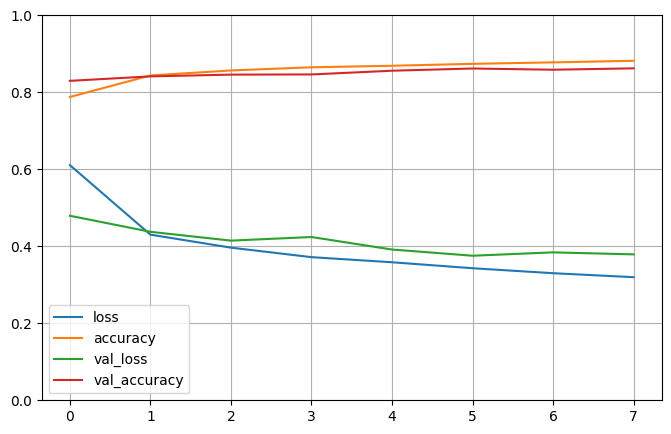

In [32]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [34]:
#let's do additional training of the last three layers
for i, layer in enumerate(model.layers):
    layer._name = 'layer_' + str(i)
    

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


modified_model = Sequential([
   conv_base,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(10, activation="softmax"),
])

In [35]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


history = model.fit(
    X_train, y_train, epochs=2, verbose=1, batch_size=128, validation_split=0.2
)

Epoch 1/2


375/375 [==============================] - 2084s 6s/step - loss: 0.2899 - accuracy: 0.8944 - val_loss: 0.3542 - val_accuracy: 0.8708
Epoch 2/2
375/375 [==============================] - 2020s 5s/step - loss: 0.2852 - accuracy: 0.8960 - val_loss: 0.3525 - val_accuracy: 0.8714


In [36]:
results = model.evaluate(X_test, y_test)
print(results)

313/313 [==============================] - 485s 2s/step - loss: 0.3629 - accuracy: 0.8699
[0.3628709614276886, 0.8698999881744385]


Висновок: порівнюючи звичайну згорткову мережу та згорткову мережу, що використовує VGG16 в якості згорткової основи, можемо помітити, що звичайна мережа показала вищу точність при однаковому розмірі батчу та однаковій кількості навчальних епох. VGG16 навіть з донавчанням трьох останніх шарів в 2 єпохи, не змогла показати точності звичайної згорткової мережі.